# PROJET 10
# DÉTECTER DES FAUX BILLETS AVEC PYTHON

##   IMPORTATION DES LIBRAIRIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.api as sms
from scipy import stats
import pylab 
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as stats




from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

-------
## IMPORTATION DES DONNÉES
------

In [2]:
# Importer le dataset billets
data = pd.read_csv('billets.csv',sep = ';')
billets=data.copy()
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


#### 1. DEFFINITION DES VARIABLES
Nous disposons actuellement de six informations géométriques sur un
billet :
  - is_guenine : une variable booléenne qui indique si le billet est authentique (True) ou non (False).
  - length : la longueur du billet (en mm) ;
  - height_left : la hauteur du billet (mesurée sur le côté gauche, en
mm) ;
  - height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
  - margin_up : la marge entre le bord supérieur du billet et l'image de
celui-ci (en mm) ;
  - margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm) ;
  - diagonal : la diagonale du billet (en mm).

In [3]:
data.shape

(1500, 7)

####  INSPECTION DES DONNÉES

In [4]:
# vérifier les valeurs que prend la colonne is_genuine (variable cible)
billets['is_genuine'].unique()

array([ True, False])

In [5]:
# Encoder la variable is_genuine
billets['is_genuine'].replace([False,True], [0,1], inplace=True)
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [6]:
# Résumé concis du DataFrame.
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.2 KB


In [7]:
# Vérification des valeurs manquantes
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

#### 37 valeurs manquantes pour la variable margin_low 

In [8]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


#### EXPLORATION DE LA DISTRIBUTIONS DES VARIABLES ET LES VALEURS ABERRANTES

<Axes: ylabel='margin_low'>

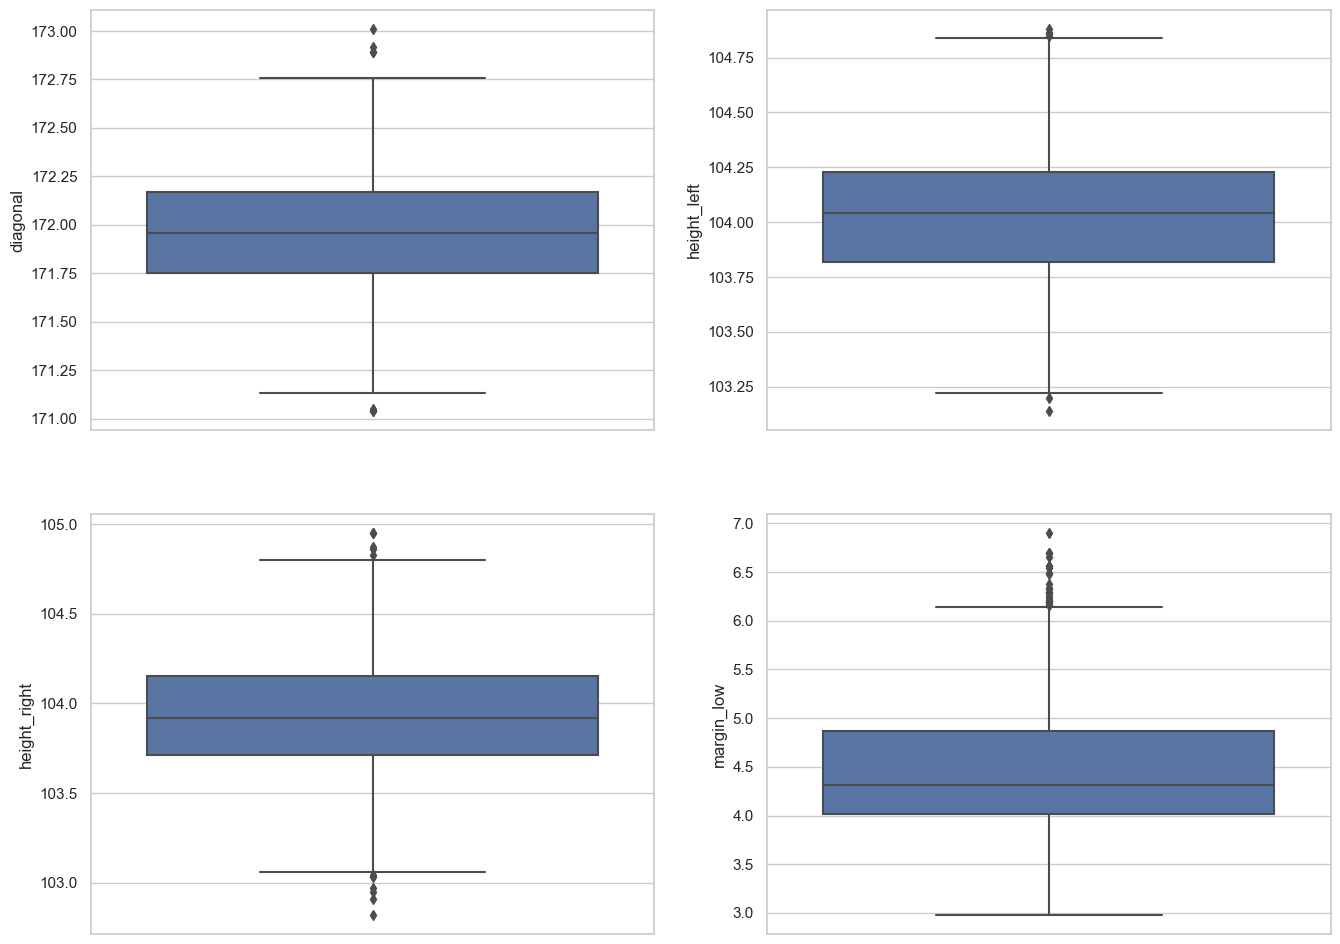

In [9]:
# Afficher des boxplot
plt.figure(figsize=(16, 12))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,y='diagonal')
plt.subplot(222)
sns.boxplot(data=billets, y='height_left')
plt.subplot(223)
sns.boxplot(data=billets, y='height_right')
plt.subplot(224)
sns.boxplot(data=billets,y='margin_low')

<Axes: ylabel='length'>

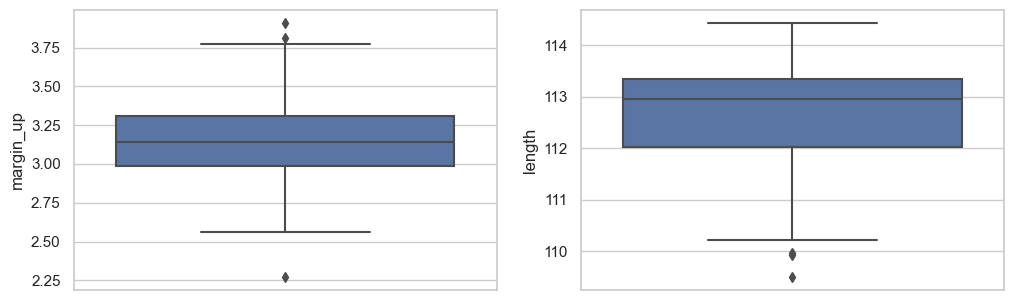

In [10]:
# Afficher des boxplot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')
plt.subplot(222)
sns.boxplot(data=billets,  y='length')

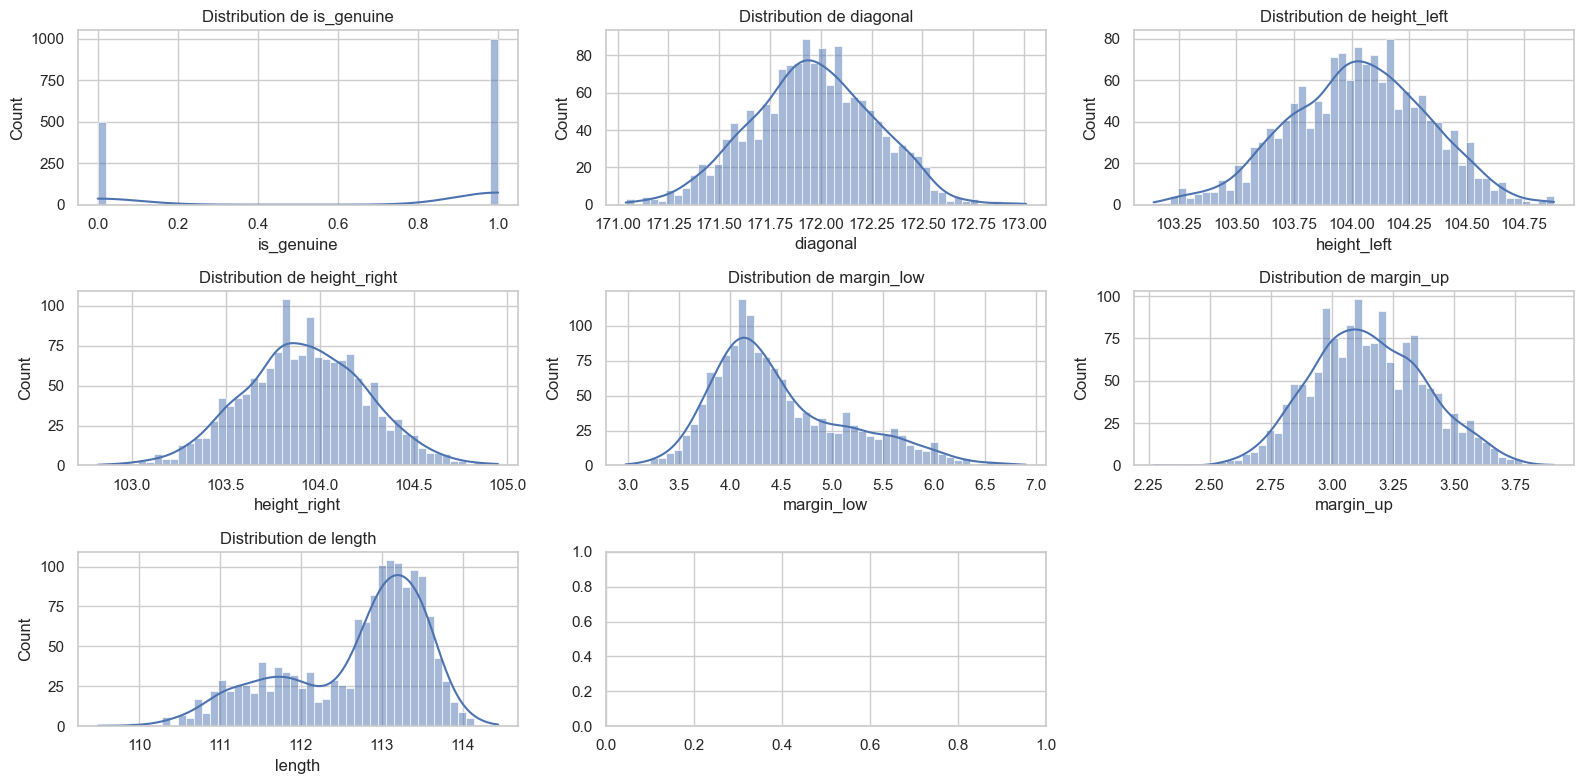

In [11]:
# Liste des noms des variables (colonnes du DataFrame 'billets') qui seront visualisées
variables = ["is_genuine", "diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]

# Création d'une grille de subplots 3x3 avec une taille de figure spécifiée
fig, axes = plt.subplots(3, 3, figsize=(16, 8))

# Boucle à travers chaque variable dans la liste 'variables'
for i, var in enumerate(variables):
# Calcul des indices de ligne et de colonne pour le subplot actuel
    row = i // 3
    col = i % 3
# Création d'un histogramme pour la variable en cours dans la case [row, col]
    sns.histplot(x=billets[var], bins=50, kde=True, ax=axes[row, col])
# Définition du titre du subplot
    axes[row, col].set_title(f"Distribution de {var}")

# Supprimez tout axe inutilisé (dans ce cas, l'axe en bas à droite)
axes[2, 2].axis('off')

# Ajustement de l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()
plt.show()


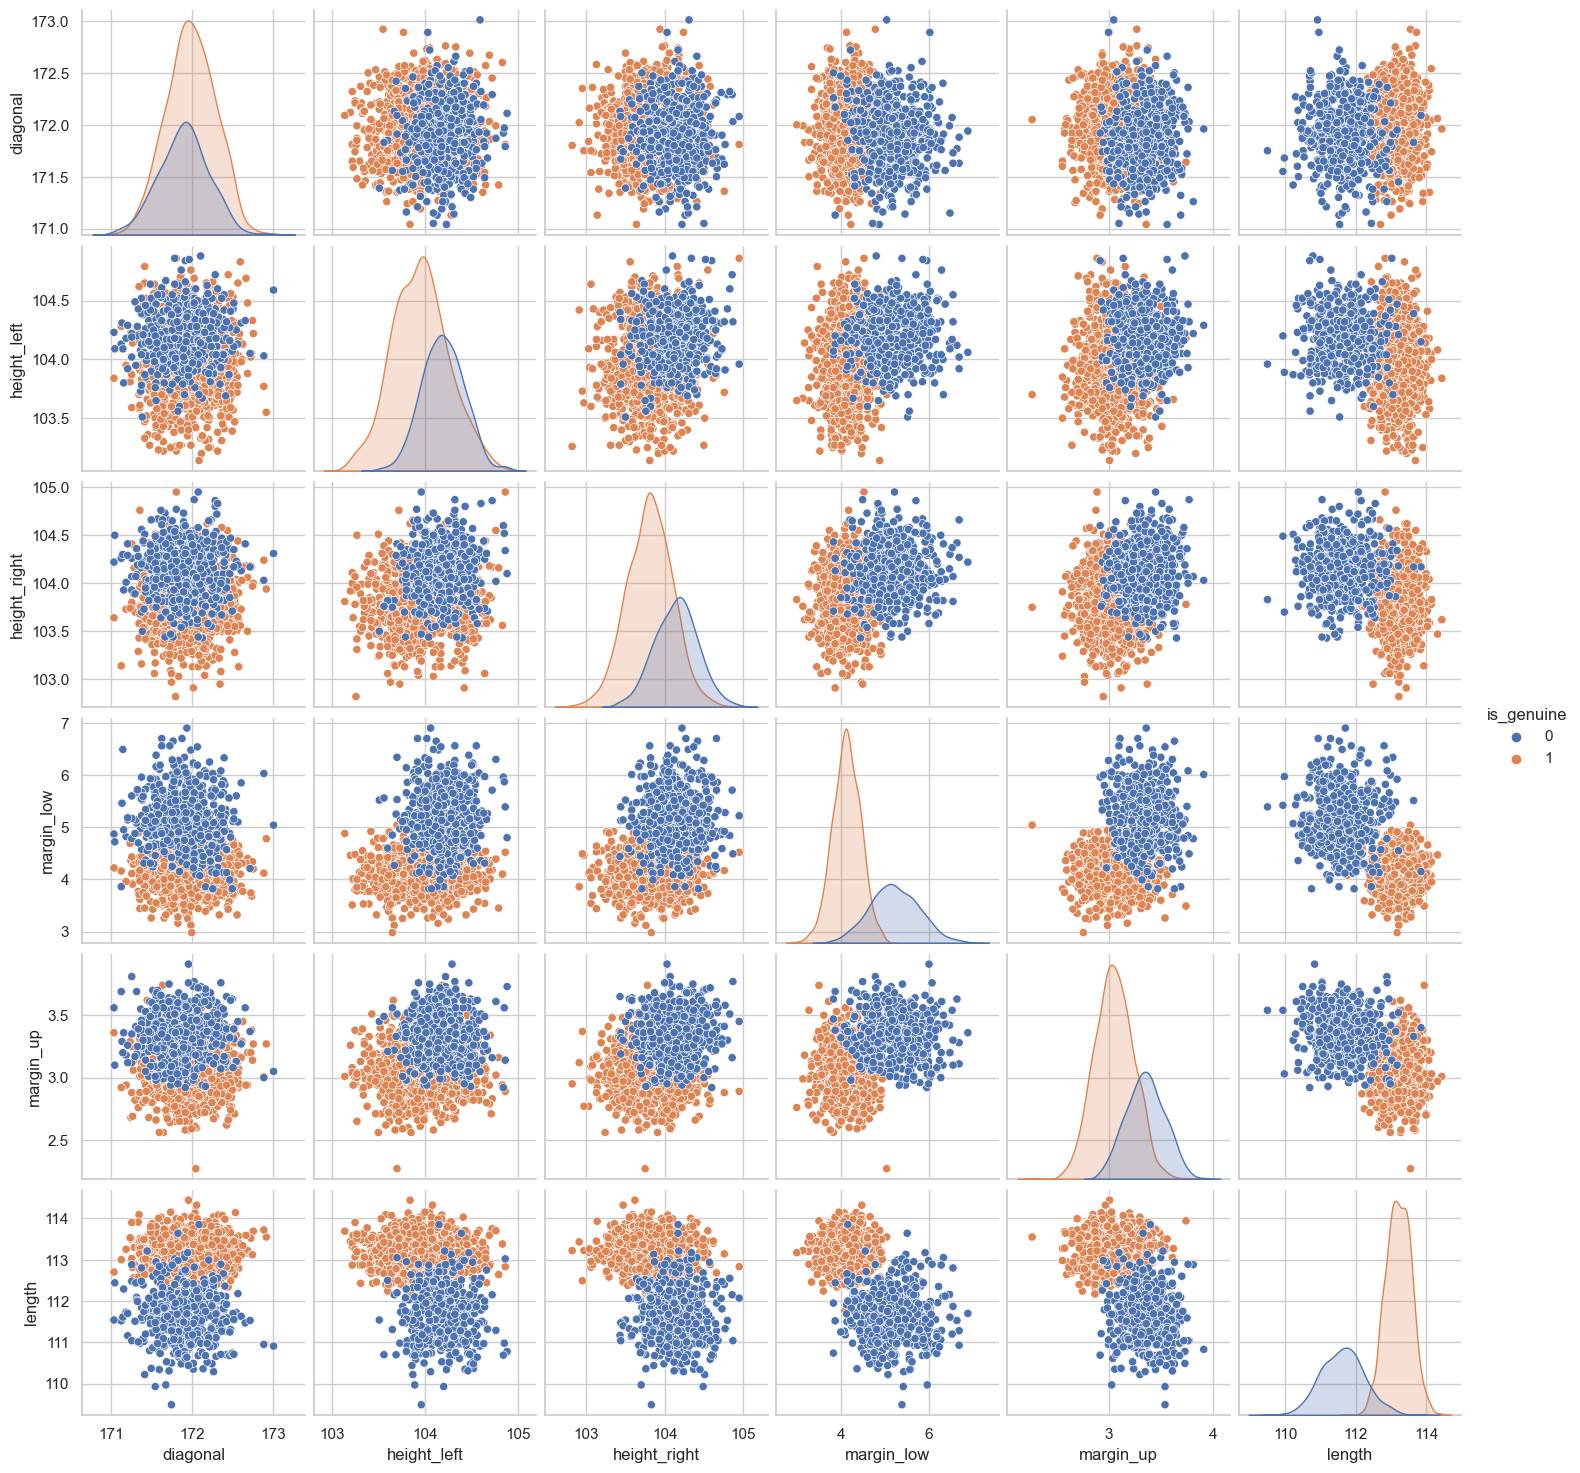

In [12]:
# générer une matrice de graphiques, explorant les relations et distributions de toutes les variables dans le DataFrame 'billets'
sns.pairplot(billets, hue = "is_genuine")

#### LES MOYENNES

In [13]:
# afficher les moyennes de variables
billets.mean()

is_genuine        0.666667
diagonal        171.958440
height_left     104.029533
height_right    103.920307
margin_low        4.485967
margin_up         3.151473
length          112.678500
dtype: float64

In [14]:
# Tableau des corrélations
billets.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


#### Le tableau des corrélations indique comment chaque paire de variables est liée l'une à l'autre. Voici quelques points clés sur les corrélations observées :

is_genuine et length ont une forte corrélation positive (r = 0.849), suggérant que la longueur est un bon indicateur de l'authenticité d'un billet.
is_genuine est également fortement corrélé négativement avec margin_low (r = −0.783) et margin_up (r=−0.606), ce qui signifie que des marges plus petites sont associées à des billets authentiques.
Les corrélations entre les mesures physiques du billet (diagonal, height_left, height_right, margin_low, margin_up, length) varient de faibles à modérées, indiquant qu'il existe certaines relations linéaires entre ces caractéristiques, mais elles ne sont pas très fortes.


<Axes: >

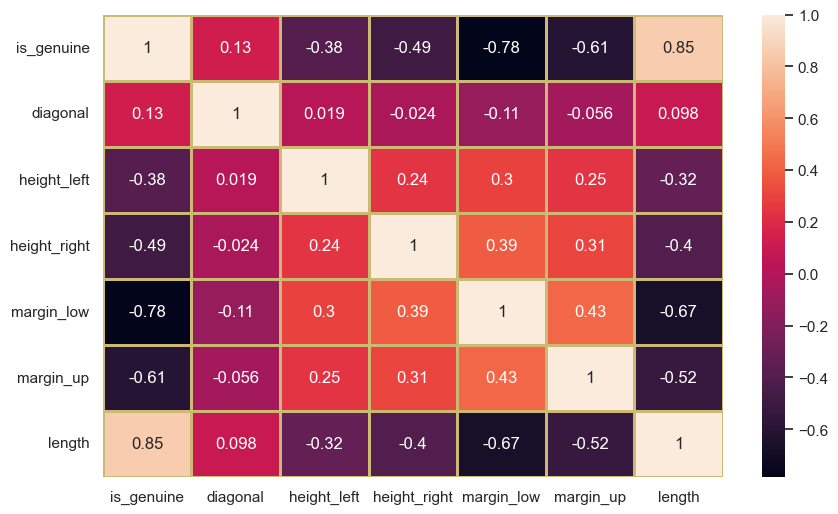

In [15]:
# Création d'une heatmap des coefficients de corrélation entre les différentes colonnes
plt.figure(figsize = (10,6))
sns.heatmap(billets.corr(), annot = True, linewidths = 2, linecolor = "y")

### 2. TRAITEMENT DES VALEURS MANQUANTES

## régression linéaire pour compléter les valeurs manquantes

In [16]:
# dataset sans les valeurs manquantes
analyse_billets=billets.dropna()
analyse_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


## On va appliquer la régression linéaire sur le dataframe analyse_billets (qui ne contient pas les valeurs manquantes) pour compléter les valeurs manquantes

### CONSTRUCTION DU MODÈLE DE RÉGRESSION LINÉAIRE

In [17]:
### Billets sans margin_low (valeurs manquantes)
billets_manquants = billets[billets["margin_low"].isnull()]

In [18]:
# extraction cinq colonnes spécifiques du DataFrame analyse_billets, les assigne à la variable X, puis affiche le contenu de X
X = analyse_billets[["diagonal", "height_left", "height_right", "margin_up", "length"]]
X

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...
1495,171.75,104.38,104.17,3.09,111.28
1496,172.19,104.63,104.44,3.37,110.97
1497,171.80,104.01,104.12,3.36,111.95
1498,172.06,104.28,104.06,3.46,112.25


In [19]:
# On sélectionne la colonne "margin_low" du DataFrame analyse_billets, l'assigne à la variable y, et affiche le DataFrame y.
y = analyse_billets[["margin_low"]]
y

,margin_low
0,4.52
1,3.77
2,4.40
3,3.62
4,4.04
...,...
1495,4.42
1496,5.27
1497,5.51
1498,5.17


In [20]:
# On divise les données en ensembles d'entraînement et de test, assigne ces ensembles à des variables spécifiques, et affiche la taille de l'ensemble d'entraînement et de l'ensemble de test.X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
print("Les données d'entrainement ", X_train.shape)
print("Les données de test ", X_test.shape)

Les données d'entrainement  (1170, 5)
Les données de test  (293, 5)


In [21]:
# Création un nouvel objet de modèle de régression linéaire.
model_line = LinearRegression()

In [22]:
# Entraînement du modèle de régression linéaire sur l'ensemble d'entraînement.
model_line.fit(X_train, y_train)

LinearRegression()

In [23]:
# imprime l'ordonnée à l'origine (aussi connue sous le nom d'intercept) du modèle de régression linéaire.
print(model_line.intercept_)

[27.41402633]


In [24]:
# obtention des coefficients de la régression linéaire associés à chaque feature (variable indépendante) de 
# notre modèle.
model_line.coef_

array([[-0.12189593,  0.18058094,  0.25483862,  0.1913262 , -0.4245654 ]])

In [25]:
# R2 score R2 de la partie test
y_pred_test = model_line.predict(X_test)
R2_test_model = r2_score(y_test,y_pred_test)
round(R2_test_model,2)

0.46

#### Un R carré de 0 indiquerait qu'un modèle ne fait pas mieux qu'un simple modèle de base (par exemple, prédire la moyenne pour toutes les observations). Un R2 de 1 indiquerait une prédiction parfaite. Dans ce contexte, 0,46 se situe quelque part entre les deux, suggérant que le modèle a une certaine utilité, mais qu'il y a encore une grande partie de la variance qui n'est pas capturée.
  

In [26]:
# R2 amélioré en utilisant la Cross validation 
cross_val = cross_val_score(model_line ,X_train ,y_train ,cv=5) # nombre de tentatives "5"
cv_mean = cross_val.max()
round(cv_mean,2)

0.57

#### Un R carré de 0,57 signifie que le modèle explique 57% de la variance de la variable dépendante en moyenne sur l'ensemble des partitions de la validation croisée. C'est une amélioration par rapport au 0,46 initial et cela suggère que le modèle a une bonne capacité explicative.

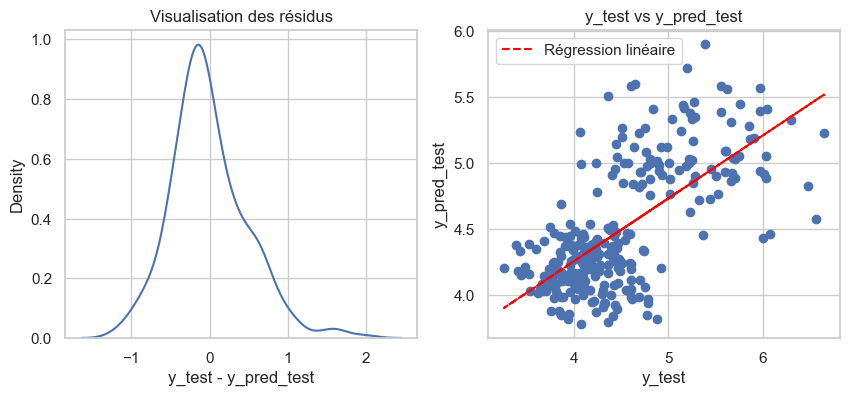

In [27]:
# Graphiques de traçage
# Tracé résiduel des données
fig, ax = plt.subplots(1,2,figsize = (10,4))
ax[0].set_title('Visualisation des résidus')
sns.distplot((y_test-y_pred_test),hist = False,ax = ax[0])
ax[0].set_xlabel('y_test - y_pred_test')
    
# Y_test vs Y_train Diagramme de dispersion
ax[1].set_title('y_test vs y_pred_test')
ax[1].scatter(x = y_test, y = y_pred_test)
ax[1].set_xlabel('y_test')
ax[1].set_ylabel('y_pred_test')
    

# Ajoutez une droite de régression
# Convertir y_test et y_pred_test en tableaux 1D
y_test = np.ravel(y_test)
y_pred_test = np.ravel(y_pred_test)
slope, intercept = np.polyfit(y_test, y_pred_test, 1)
ax[1].plot(y_test, slope * y_test + intercept, color='red', linestyle='--', label='Régression linéaire')
ax[1].legend()

plt.show()

#### Visualisation des résidus : Le graphique de gauche montre la distribution des résidus, c'est-à-dire les différences entre les valeurs prédites et les valeurs réelles. Une distribution normale centrée autour de zéro indiquerait que le modèle prédit bien les valeurs. Dans le graphique, nous voyons que la distribution des résidus semble être centrée autour de zéro, ce qui est un bon signe.

#### y_test vs y_pred_test : Le graphique de droite montre un nuage de points des valeurs prédites par rapport aux valeurs réelles. La doite rouge représente l'endroit où les valeurs prédites seraient parfaitement égales aux valeurs réelles. Plus les points sont proches de cette ligne, meilleure est la prédiction. Le graphique montre que bien que beaucoup de points soient proches de la ligne, il y a une dispersion qui suggère que pour certaines observations, le modèle prédit moins précisément.

### Validation du modèle

#### homoscédastiscité

In [28]:
residuals = y_test - y_pred_test

In [29]:
# Nous devons utiliser X_test pour correspondre à y_test, puisque les résidus sont calculés sur l'ensemble de test.
# Nous ajoutons également une colonne constante pour le modèle, nécessaire pour le test de Breusch-Pagan.

# Exécution du test de Breusch-Pagan pour l'homoscédasticité avec le bon ensemble de variables explicatives
bp_test = het_breuschpagan(residuals, X_test.assign(const=1))  # Ajout d'une constante pour le test

# Récupération de la p-value du test
bp_pvalue = bp_test[1]

print('Modèle p value test Breusch-Pagan:', bp_pvalue)

Modèle p value test Breusch-Pagan: 0.01342611738007516


#### La p-value obtenue du test est d'environ 0.0134.
#### Cette p-value est inférieure au seuil typique de 0.05, ce qui signifie que nous pouvons rejeter l'hypothèse nulle que les variances des erreurs sont constantes (homoscédasticité).
#### Le rejet de l'hypothèse nulle suggère qu'il y a une hétéroscédasticité significative dans le modèle.
#### La présence d'hétéroscédasticité indique que les résultats pourraient être améliorés, et que l'on devrait examiner les données plus en détail ou envisager des modèles alternatifs.

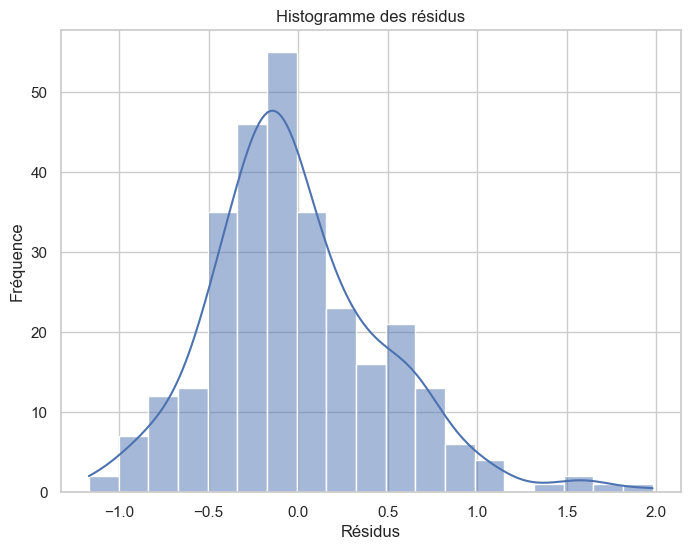

In [30]:
# Création d'un histogramme des résidus
plt.figure(figsize=(8, 6))
plt.title('Histogramme des résidus')
sns.histplot(residuals, kde=True)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

#### La distribution est presque normale

In [31]:
# On s'assure que les résidus sont unidimensionnels
residuals = (y_test - y_pred_test).flatten()

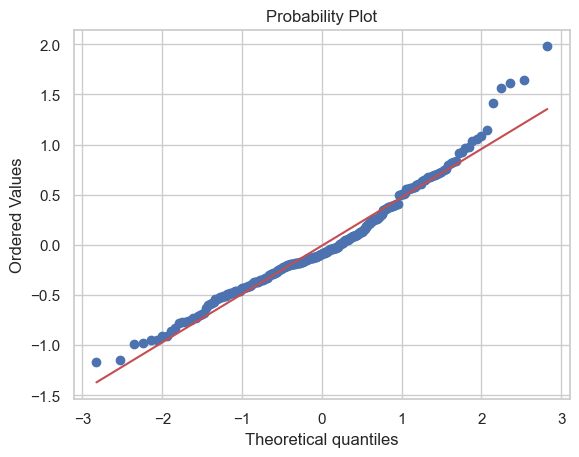

In [32]:
# # Création d'un QQ-plot pour les résidus
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

#### Ils suivent cette droite linéaire (calculer à partir des résidus)

In [33]:
prediction = model_line.predict(X)
residual = (y - prediction)

In [34]:
# appliquer le test de shapiro pour confirmer la normalité des residus
from scipy.stats import shapiro
x, pval = shapiro(residual)
print(pval)

1.082276282482475e-10


####  la p-valeur est extrêmement petite (1.082276282482475e−10), ce qui est bien en dessous des seuils couramment utilisés (0,05 ou 0,01). Par conséquent, nous avez des preuves statistiques suffisantes pour rejeter l'hypothèse nulle et conclure que les résidus ne sont pas normalement distribués.

In [35]:
# Calcule de Rsquare
import statsmodels.api as sm
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Mon, 06 Nov 2023   Prob (F-statistic):          2.60e-202
Time:                        14:06:12   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382   

#### R carré = 0.477: Ceci signifie que le modèle explique 47,7% de la variance de la variable dépendante margin_low. R carré ajusté est très proche du R carré, ce qui suggère que la plupart des prédicteurs contribuent significativement au modèle. 
####  Toutes les variables sont significatives (la pvaleur est inférieure à 0,05).
#### Enfin, on retient notre modèle linéaire pour effectuer des prédictions.

### Prédictions en utilisant l'ensemble de données de test

In [36]:
# Création du modèle de régression linéaire que nous avons précédemment entraîné pour faire des prédictions 
# sur notre ensemble de test (X_test).
predictions = model_line.predict(X_test)

In [37]:
predictions

array([[5.24323876],
       [4.14041456],
       [4.0700556 ],
       [4.46338616],
       [4.2417091 ],
       [3.79874239],
       [5.0937016 ],
       [3.95984726],
       [3.85494854],
       [4.3526127 ],
       [4.13684677],
       [5.58337118],
       [5.44909386],
       [3.98157429],
       [4.21610427],
       [3.84689975],
       [4.39158782],
       [4.39775019],
       [4.09847539],
       [4.37658145],
       [4.1975359 ],
       [4.03696732],
       [4.81698359],
       [3.88380405],
       [4.08253872],
       [4.95144944],
       [4.47818994],
       [3.84770752],
       [4.40839537],
       [4.93831002],
       [5.02383005],
       [4.88379291],
       [4.99806785],
       [4.23920736],
       [4.51731029],
       [4.99102585],
       [4.06074147],
       [4.11806307],
       [5.05639625],
       [3.87415013],
       [4.01265228],
       [5.39667303],
       [4.01536443],
       [4.08228793],
       [4.14676359],
       [4.25869615],
       [5.28177623],
       [4.580

In [38]:
print('La performance du modele sur la base des données du test :', model_line.score(X_test, y_test))

La performance du modele sur la base des données du test : 0.45679511388282634


In [39]:
# On affiche 'y_test'
y_test

array([5.13, 4.01, 3.74, 4.1 , 3.78, 4.36, 5.61, 4.21, 3.95, 4.23, 3.94,
       4.6 , 5.76, 3.79, 4.27, 4.41, 3.53, 4.47, 4.01, 3.95, 3.82, 4.31,
       4.69, 3.76, 3.71, 5.11, 4.45, 3.86, 3.68, 5.97, 5.25, 4.81, 4.82,
       4.1 , 3.75, 4.08, 4.11, 4.7 , 6.03, 4.23, 3.82, 5.97, 3.62, 4.  ,
       3.9 , 4.16, 5.85, 6.56, 4.1 , 4.07, 5.27, 4.17, 4.02, 4.51, 3.48,
       4.6 , 4.27, 3.87, 5.2 , 4.43, 5.02, 3.89, 3.91, 4.33, 4.11, 4.84,
       4.36, 3.95, 4.73, 4.18, 4.  , 4.9 , 5.37, 4.18, 3.97, 6.01, 4.04,
       4.59, 3.83, 5.97, 4.76, 4.39, 3.96, 4.69, 4.51, 3.74, 3.41, 5.25,
       3.81, 4.08, 4.62, 3.26, 4.2 , 4.36, 4.18, 4.1 , 4.04, 4.24, 4.1 ,
       4.41, 5.16, 3.79, 4.92, 4.4 , 4.11, 3.98, 4.13, 4.79, 4.18, 5.23,
       4.42, 4.31, 3.94, 3.85, 3.98, 4.46, 4.23, 4.39, 6.08, 4.92, 4.69,
       4.08, 4.41, 5.04, 4.39, 4.23, 3.86, 4.41, 4.88, 4.16, 3.91, 5.17,
       3.76, 4.15, 4.42, 4.44, 4.54, 5.67, 4.49, 4.81, 3.54, 4.61, 5.33,
       5.22, 6.48, 5.02, 4.32, 4.36, 4.03, 3.99, 4.

In [40]:
billets_manquants

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,171.94,103.89,103.45,NaN,3.25,112.79
99,1,171.93,104.07,104.18,NaN,3.14,113.08
151,1,172.07,103.80,104.38,NaN,3.02,112.93
197,1,171.45,103.66,103.80,NaN,3.62,113.27
241,1,171.83,104.14,104.06,NaN,3.02,112.36
251,1,171.80,103.26,102.82,NaN,2.95,113.22
284,1,171.92,103.83,103.76,NaN,3.23,113.29
334,1,171.85,103.70,103.96,NaN,3.00,113.36
410,1,172.56,103.72,103.51,NaN,3.12,112.95
413,1,172.30,103.66,103.50,NaN,3.16,112.95


In [41]:
# On sélectionne cinq colonnes spécifiques ("diagonal", "height_left", "height_right", "margin_up", et "length") du DataFrame billets_manquants et assigne ce sous-ensemble de données à une nouvelle variable appelée X_valid
X_valid = billets_manquants[["diagonal", "height_left", "height_right", "margin_up","length"]]

In [42]:
# On prédit les valeurs de la colonne 'margin_low' en utilisant les données contenues dans X_valid et 
# assigne ces valeurs prédites à une nouvelle colonne appelée 'margin_low' dans le DataFrame billets_manquants.
billets_manquants['margin_low'] = model_line.predict(X_valid)

In [43]:
# On concatène deux DataFrames, analyse_billets et billets_manquants.
Billets_final = pd.concat([analyse_billets, billets_manquants])


In [44]:
Billets_final

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.520000,2.89,112.83
1,1,171.46,103.36,103.66,3.770000,2.99,113.09
2,1,172.69,104.48,103.50,4.400000,2.94,113.16
3,1,171.36,103.91,103.94,3.620000,3.01,113.51
4,1,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,0,172.17,104.49,103.76,5.082829,2.93,111.21
1315,0,172.08,104.15,104.17,4.768279,3.40,112.29
1347,0,171.72,104.46,104.12,5.736217,3.61,110.31
1435,0,172.66,104.33,104.41,5.170001,3.56,111.47


In [45]:
# On calcule et affiche le nombre de valeurs manquantes (NaN ou null)
Billets_final.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

## REGRESSION LOGISTIQUE

In [46]:
# Création d'un dataframe "X"
X = Billets_final[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]]

In [47]:
X

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.520000,2.89,112.83
1,171.46,103.36,103.66,3.770000,2.99,113.09
2,172.69,104.48,103.50,4.400000,2.94,113.16
3,171.36,103.91,103.94,3.620000,3.01,113.51
4,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...
1303,172.17,104.49,103.76,5.082829,2.93,111.21
1315,172.08,104.15,104.17,4.768279,3.40,112.29
1347,171.72,104.46,104.12,5.736217,3.61,110.31
1435,172.66,104.33,104.41,5.170001,3.56,111.47


In [48]:
# Création d'un dataframe "y"
y = Billets_final["is_genuine"]

In [49]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1303    0
1315    0
1347    0
1435    0
1438    0
Name: is_genuine, Length: 1500, dtype: int64

#### Problème de classification (Problème supervisé) Donc régression logistique car "y" est une variable qualitative pour si les billets Vrai ou Faux

In [50]:
# On divise les données X et y en ensembles d'entraînement et de test avec une proportion de test de 20%, 
# assigne ces sous-ensembles à des variables, et affiche la taille des ensembles d'entraînement et de test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
print("Les données d'entrainement ", X_train.shape)
print("Les données de test ", X_test.shape)

Les données d'entrainement  (1200, 6)
Les données de test  (300, 6)


In [51]:
# On initialise un modèle de régression logistique sans spécifier de paramètres (utilisant donc les valeurs 
# par défaut)
model_reg = LogisticRegression()

In [52]:
# On entraîne le modèle de régression logistique.
model_reg.fit(X_train, y_train)

LogisticRegression()

In [53]:
# On utilise le modèle de régression logistique, model_reg, qui a été entraîné précédemment, pour faire 
# des prédictions sur l'ensemble de données de test X_test, et stocke ces prédictions dans la variable 
# predictions_reg.
predictions_reg = model_reg.predict(X_test)

In [54]:
print('La performance du modèle sur la base des données de test :', model_reg.score(X_test, y_test))

La performance du modèle sur la base des données de test : 0.9866666666666667


#### La performance du modèle de régression logistique sur la base des données de test est d'environ 98.67%. Cela signifie que le modèle a correctement prédit l'authenticité des billets dans 98.67% des cas dans l'ensemble de test, ce qui est une performance très élevée.

### MATRICE DE CONFUSION

In [55]:
predict_reg = model_reg.predict(X)

In [56]:
# Calculer la matrice de confusion régression logistique
confusion = confusion_matrix(Billets_final['is_genuine'], model_reg.predict(X))

# Extraire les valeurs de la matrice de confusion
tn, fp, fn, tp = confusion.ravel()

# Afficher les résultats
print('Vrais négatifs :', tn)
print('Vrais positifs :', tp)
print('Faux négatifs :', fn)
print('Faux positifs :', fp)
print(confusion)

Vrais négatifs : 490
Vrais positifs : 993
Faux négatifs : 7
Faux positifs : 10
[[490  10]
 [  7 993]]


#### Le modèle a correctement prédit 993 cas de billets non authentiques (vrais négatifs).
#### Il a correctement prédit 203 cas de billets authentiques (vrais positifs).
#### Il y a 10 faux positifs, où le modèle a prédit que les billets étaient authentiques alors qu'ils ne l'étaient pas.
#### Il y a également 7 faux négatifs, où le modèle a prédit que les billets n'étaient pas authentiques alors qu'ils l'étaient.
#### Globalement, la matrice de confusion indique une performance élevée du modèle avec un faible nombre de fausses prédictions.

## Aplication de Kmeans

In [57]:
# Création d'un Dataframe pour effectuer l'analyse en composante principale
Billets_final_kmeans = Billets_final

In [58]:
Billets_final

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.520000,2.89,112.83
1,1,171.46,103.36,103.66,3.770000,2.99,113.09
2,1,172.69,104.48,103.50,4.400000,2.94,113.16
3,1,171.36,103.91,103.94,3.620000,3.01,113.51
4,1,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,0,172.17,104.49,103.76,5.082829,2.93,111.21
1315,0,172.08,104.15,104.17,4.768279,3.40,112.29
1347,0,171.72,104.46,104.12,5.736217,3.61,110.31
1435,0,172.66,104.33,104.41,5.170001,3.56,111.47


In [59]:
# Centrer et reduire nos données.
scaler = StandardScaler()
x_scaled = scaler.fit_transform(Billets_final_kmeans)
x_scaled

array([[ 0.70710678, -0.48653957,  2.77412327, ...,  0.05522783,
        -1.128325  ,  0.17365114],
       [ 0.70710678, -1.63372936, -2.23653528, ..., -1.08209771,
        -0.69679916,  0.47166629],
       [ 0.70710678,  2.3978233 ,  1.50475644, ..., -0.12674425,
        -0.91256208,  0.55190114],
       ...,
       [-1.41421356, -0.78153123,  1.43794766, ...,  1.8995413 ,
         1.97866106, -2.71480344],
       [-1.41421356,  2.29949275,  1.00369058, ...,  1.04091105,
         1.76289814, -1.38519737],
       [-1.41421356, -0.19154792,  0.83666863, ...,  1.01561016,
         0.38201544, -1.36227312]])

In [60]:
# déterminer le nombre optimal de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(x_scaled)
    wcss.append(kmeans.inertia_)

In [61]:
wcss

[10500.0,
 5848.309617185832,
 5132.656833981846,
 4730.6910934236075,
 4398.1361333305285,
 4145.562466796719,
 3966.4306603630175,
 3781.606465914214,
 3653.7104317175545,
 3505.5658388887523]

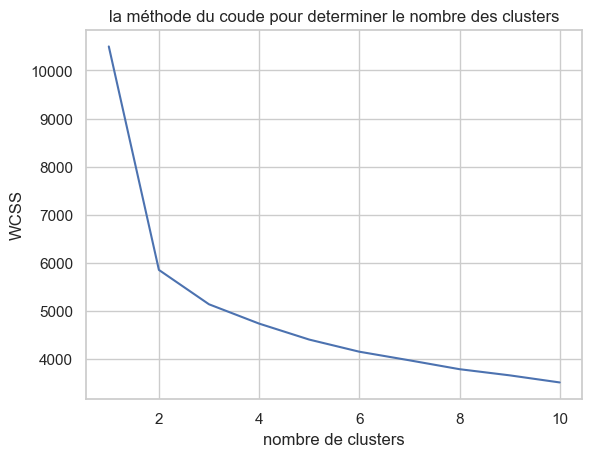

In [62]:
# Visualisation pour déterminer le nombre de clusters avec la méthode du coude
plt.plot(range (1, 11), wcss )
plt.title('la méthode du coude pour determiner le nombre des clusters')
plt.xlabel('nombre de clusters')
plt.ylabel('WCSS')
plt.savefig('Kmeans_la méthode du coude pour determiner le nombre des clusters.jpg')
plt.show ()

#### En regardant le graphique, ce "coude" semble se situer autour de 2 à 4 clusters, où l'inertie commence à diminuer plus lentement. on choisit 2 clusters.

In [63]:
# On initialise un modèle de clustering K-Means
kmeans_zone = KMeans(n_clusters = 2, init = 'k-means++')

In [64]:
# Ajustement du modèle K-Means aux données standardisées 'x_scaled'.
kmeans_zone.fit(x_scaled)

KMeans(n_clusters=2)

In [65]:
# Prédiction des clusters pour les données standardisées 'x_scaled' en utilisant le modèle K-Means.
clusters = kmeans_zone.predict(x_scaled)

In [66]:
Billets_final_kmeans

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.520000,2.89,112.83
1,1,171.46,103.36,103.66,3.770000,2.99,113.09
2,1,172.69,104.48,103.50,4.400000,2.94,113.16
3,1,171.36,103.91,103.94,3.620000,3.01,113.51
4,1,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,0,172.17,104.49,103.76,5.082829,2.93,111.21
1315,0,172.08,104.15,104.17,4.768279,3.40,112.29
1347,0,171.72,104.46,104.12,5.736217,3.61,110.31
1435,0,172.66,104.33,104.41,5.170001,3.56,111.47


In [67]:
# Ajout des prédictions de clusters à 'etude_marche_kmeans', suppression de la colonne 'label', puis affichage 
# du DataFrame mis à jour.
Billets_final_kmeans['cluster']=clusters
# Billets_final_kmeans = Billets_final_kmeans.drop("label", axis = 1)
Billets_final_kmeans

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,1,171.81,104.86,104.95,4.520000,2.89,112.83,1
1,1,171.46,103.36,103.66,3.770000,2.99,113.09,0
2,1,172.69,104.48,103.50,4.400000,2.94,113.16,0
3,1,171.36,103.91,103.94,3.620000,3.01,113.51,0
4,1,171.73,104.28,103.46,4.040000,3.48,112.54,0
...,...,...,...,...,...,...,...,...
1303,0,172.17,104.49,103.76,5.082829,2.93,111.21,1
1315,0,172.08,104.15,104.17,4.768279,3.40,112.29,1
1347,0,171.72,104.46,104.12,5.736217,3.61,110.31,1
1435,0,172.66,104.33,104.41,5.170001,3.56,111.47,1


#### Les données ont été segmentées en deux clusters, indiqués par les étiquettes 0 et 1 dans le tableau de résultats. Nous pouvons maintenant analyser ces clusters pour comprendre comment les billets sont regroupés en fonction de leurs caractéristiques.

In [68]:
# Calculer la matrice de confusion pour K-Means
confusion_kmeans = confusion_matrix(y, clusters)

# Extraire les valeurs de la matrice de confusion
tn_kmeans, fp_kmeans, fn_kmeans, tp_kmeans = confusion_kmeans.ravel()

# Afficher les résultats
print('Vrais négatifs (K-Means) :', tn_kmeans)
print('Vrais positifs (K-Means) :', tp_kmeans)
print('Faux négatifs (K-Means) :', fn_kmeans)
print('Faux positifs (K-Means) :', fp_kmeans)
print(confusion_kmeans)

Vrais négatifs (K-Means) : 2
Vrais positifs (K-Means) : 1
Faux négatifs (K-Means) : 999
Faux positifs (K-Means) : 498
[[  2 498]
 [999   1]]


#### Cette matrice de confusion indique une situation où le modèle a un très grand nombre de faux négatifs (999) par rapport aux vrais positifs (1), ce qui signifie que le modèle a du mal à détecter les cas positifs réels. De plus, il y a un nombre élevé de faux positifs (498), ce qui signifie que le modèle prédit souvent à tort que les cas sont positifs.

#### En général, cette matrice de confusion suggère que le modèle a des problèmes importants de performances et de déséquilibre de classe.

### Utilisation de I'ACP pour visualiser les données

In [69]:
# fonction pour afficher les composantes principales
def display_scree_plot (pca):
    scree = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len (scree))+1, scree.cumsum(), c="red", marker="o")
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

Nombre de composantes calculées :  6


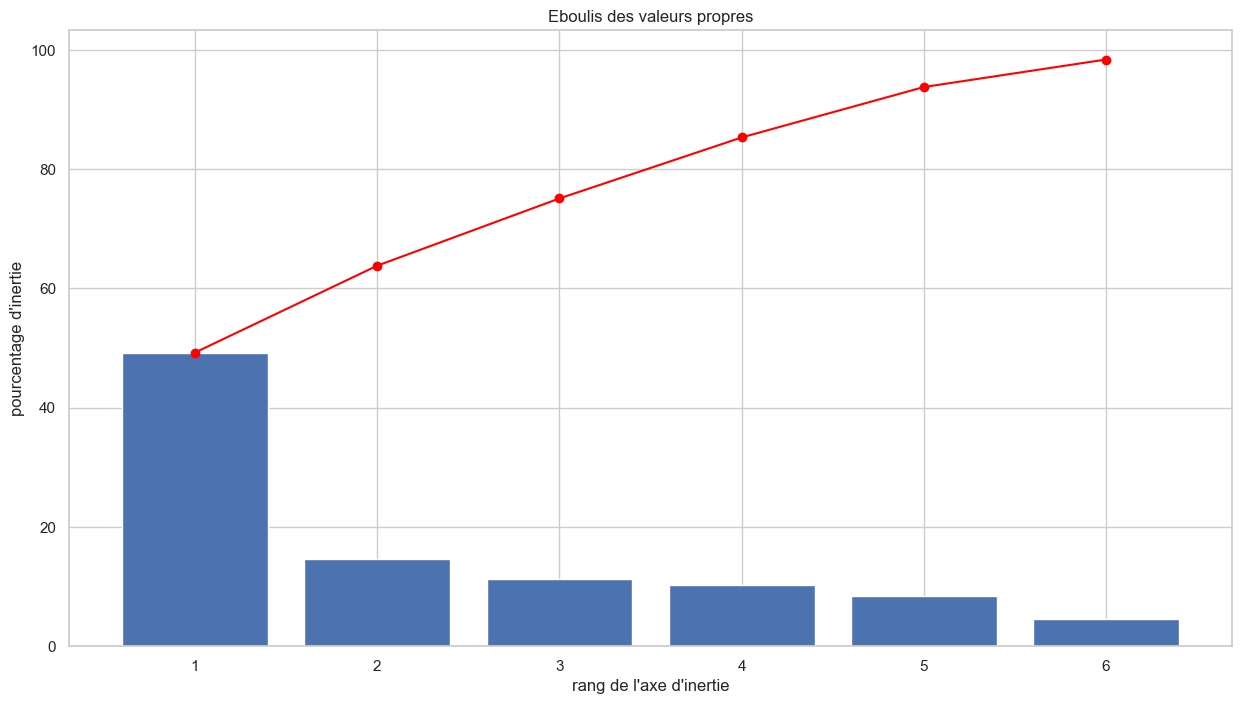

In [70]:
# choix du nombre de composantes à calculer vu qu'on a six parametres
n_comp = 6
# Calcul des composantes principales
pca = PCA(n_components=n_comp)
pca.fit(x_scaled)
print ('Nombre de composantes calculées : ', pca.n_components_)
# Eboulis des valeurs propres
plt.figure(figsize = ( 15, 8))
display_scree_plot(pca)
 #plt.savefig('ACP_Composantes_calculées.jpg')

In [71]:
# Fraction de variance expliquée par les deux premières composantes
deux_premières_variance = pca.explained_variance_ratio_[:2].sum()

# Convertir en pourcentage
deux_premiers_variance_pourcentage = deux_premières_variance * 100

print(f"Les deux premières composantes expliquent {deux_premiers_variance_pourcentage:.2f}% de la variance totale.")

Les deux premières composantes expliquent 63.82% de la variance totale.


In [72]:
# Appliquer l'acp pour avoir 2 composants du moment que 2 composants nous permettent d'avoir 63.82% de l'information.
pca = PCA(n_components=2).fit(x_scaled)
Xk_projected = pca.transform(x_scaled)

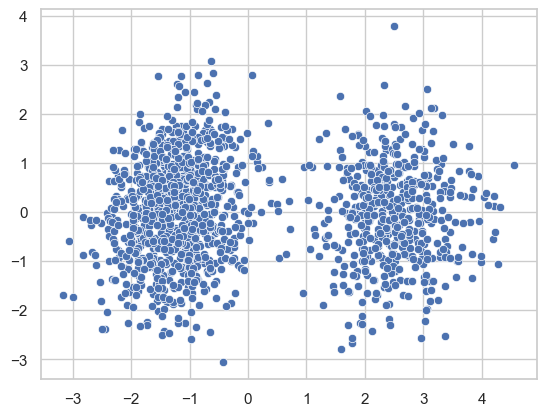

In [73]:
# dessiner les projections de x scaled sur les deux composantes qu'on a trouvé en utlisant ACP.
sns.scatterplot(data=Xk_projected, x=Xk_projected[:, 0], y=Xk_projected[:, 1], alpha=1)
plt.savefig('ACP_projection_de_x_scaled.jpg')

In [74]:
# Nous enregistrons les billets dans une variable `names` 
names = Billets_final_kmeans.index
names

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
        946,  981, 1076, 1121, 1176, 1303, 1315, 1347, 1435, 1438],
      dtype='int64', length=1500)

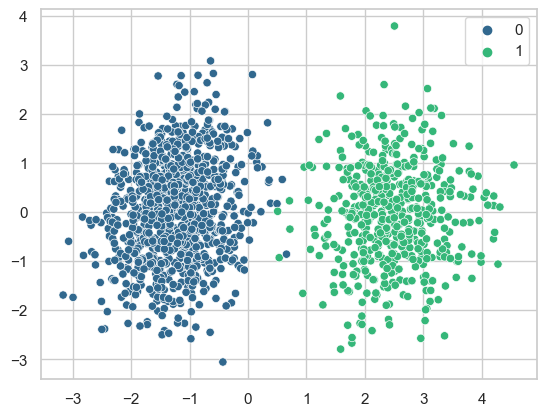

In [75]:
# Visualisation avec Kmeans 
sns.scatterplot(data=Xk_projected, x=Xk_projected[:, 0], y=Xk_projected[:, 1], palette = 'viridis', alpha=1, hue=clusters)
plt.legend()
plt.savefig('ACP_projection_data.jpg')
plt.show()

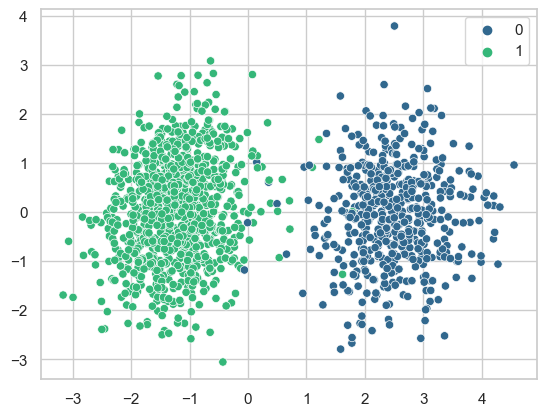

In [76]:
# Visualisation avec la régression logistique
sns.scatterplot(data=Xk_projected, x=Xk_projected[:, 0], y=Xk_projected[:, 1], palette = 'viridis', alpha=1, hue=predict_reg)
plt.legend()
plt.savefig('ACP_projection_data.jpg')
plt.show()

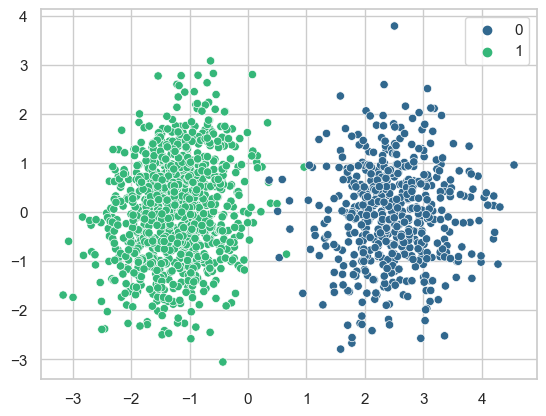

In [77]:
# Visualisation en réalité 'is_guenine'
sns.scatterplot(data=Xk_projected, x=Xk_projected[:, 0], y=Xk_projected[:, 1], palette = 'viridis', alpha=1, hue=y)
plt.legend()
plt.savefig('ACP_projection_data.jpg')
plt.show()

#### les groupes sont clairement séparés, cela indique que les composantes principales sont efficaces pour distinguer les billets authentiques des contrefaçons.

In [78]:
Billets_final

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,1,171.81,104.86,104.95,4.520000,2.89,112.83,1
1,1,171.46,103.36,103.66,3.770000,2.99,113.09,0
2,1,172.69,104.48,103.50,4.400000,2.94,113.16,0
3,1,171.36,103.91,103.94,3.620000,3.01,113.51,0
4,1,171.73,104.28,103.46,4.040000,3.48,112.54,0
...,...,...,...,...,...,...,...,...
1303,0,172.17,104.49,103.76,5.082829,2.93,111.21,1
1315,0,172.08,104.15,104.17,4.768279,3.40,112.29,1
1347,0,171.72,104.46,104.12,5.736217,3.61,110.31,1
1435,0,172.66,104.33,104.41,5.170001,3.56,111.47,1


In [79]:
x_scaled

array([[ 0.70710678, -0.48653957,  2.77412327, ...,  0.05522783,
        -1.128325  ,  0.17365114],
       [ 0.70710678, -1.63372936, -2.23653528, ..., -1.08209771,
        -0.69679916,  0.47166629],
       [ 0.70710678,  2.3978233 ,  1.50475644, ..., -0.12674425,
        -0.91256208,  0.55190114],
       ...,
       [-1.41421356, -0.78153123,  1.43794766, ...,  1.8995413 ,
         1.97866106, -2.71480344],
       [-1.41421356,  2.29949275,  1.00369058, ...,  1.04091105,
         1.76289814, -1.38519737],
       [-1.41421356, -0.19154792,  0.83666863, ...,  1.01561016,
         0.38201544, -1.36227312]])

In [80]:
model_reg.predict(X)

array([0, 1, 1, ..., 0, 0, 0])

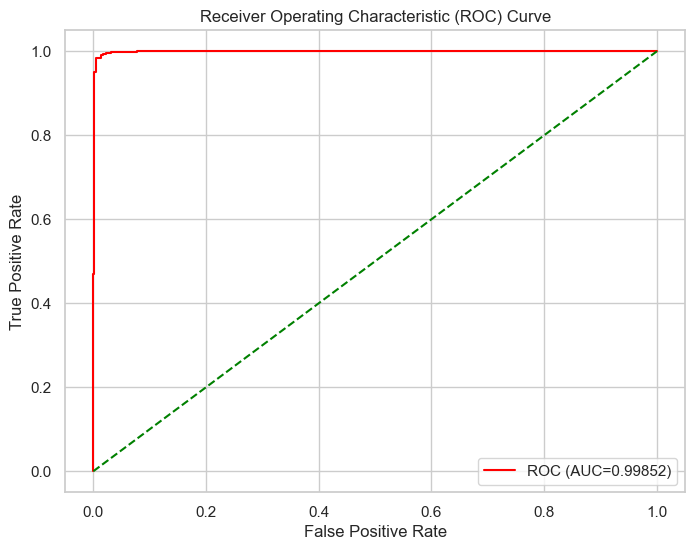

In [81]:
def plot_roc_curve(fper, tper, aucf):
    plt.figure(figsize=(8, 6))
    plt.plot(fper, tper, color='red', label=f'ROC (AUC={aucf:.5f})')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Faire des prédictions de probabilité du modèle
probabilities = model_reg.predict_proba(X)[:, 1]  # Utiliser la probabilité de la classe positive

# Calculer la courbe ROC
fper, tper, thresholds = roc_curve(Billets_final['is_genuine'], probabilities)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fper, tper)

# Tracer la courbe ROC
plot_roc_curve(fper, tper, roc_auc)

#### Notre modèle a une excellente capacité à distinguer entre les classes positives et négatives. En d'autres termes, il a une performance presque parfaite dans la classification des observations.

## Analyse prédictive

In [82]:
# On crée une fonction personnalisée nommée modelreg_predict pour effectuer des prédictions.


def modelreg_predict(new_data):
    """
    Prédit les étiquettes pour de nouvelles données en utilisant un modèle pré-entraîné.
    
    Parameters:
    - new_data : array-like or DataFrame, shape (n_samples, n_features)
      Les données sur lesquelles faire des prédictions.
    
    
    Returns:
    - predictions : array, shape (n_samples,)
      Les prédictions du modèle pour les nouvelles données.
    """
    # Charger le dataset
    data = pd.read_csv(new_data)
    # Séparation des caractéristiques (features) et de la cible (target)
    X = data.drop('id', axis=1)
    

    predictions = model_reg.predict(X) # La performance du modèle de régression logistique sur la base des données de test est d'environ 98.67%
    data['is_guenine'] = predictions
    data['is_guenine'].replace(1, 'Vrai_billet', inplace=True)
    data['is_guenine'].replace(0, 'Faux_billet', inplace=True)

    return data


# Utilisation de la fonction
# data = load_data() 
# predictions = modelreg_predict(data, model_reg)


In [83]:
modelreg_predict('billets_production.csv')

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_guenine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,Faux_billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,Faux_billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,Faux_billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,Vrai_billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,Vrai_billet
